# Characterization and Calibration using Graybox

<div class="admonition info">
    <p class="admonition-title">Info</p>
    <p>
        This guide use <code>v2</code> API of the package.
    </p>
</div>

<div class="admonition goal">
    <p class="admonition-title">Goal</p>
    <p>
        This tutorial aims to guide you thourgh a process of characterizing a predicitive model, and using the predictive model in calibrating for quantum gate using open-loop optimization (although not necessary). 
    </p>
</div>

In [1]:
import jax
import jax.numpy as jnp
import inspeqtor as sq

## Generate some synthetic data

In [2]:
data_model = sq.predefined.get_predefined_data_model_m1()
sample_size = 100
# Now, we use the noise model to performing the data using simulator.
exp_data, _, _, _ = sq.predefined.generate_single_qubit_experimental_data(
    key=jax.random.key(0),
    hamiltonian=data_model.total_hamiltonian,
    sample_size=sample_size,
    strategy=sq.predefined.SimulationStrategy.SHOT,
    qubit_inforamtion=data_model.qubit_information,
    control_sequence=data_model.control_sequence,
    method=sq.predefined.WhiteboxStrategy.TROTTER,
    trotter_steps=10_000,
)

# Now we can prepare the dataset that ready to use.
whitebox = sq.physics.make_trotterization_solver(
    data_model.ideal_hamiltonian,
    data_model.control_sequence.total_dt,
    data_model.dt,
    trotter_steps=10_000,
    y0=jnp.eye(2, dtype=jnp.complex_),
)
loaded_data = sq.utils.prepare_data(exp_data, data_model.control_sequence, whitebox)

We can inspect the experiment configuration from predefined noise model using `display` function from `flax.nnx`

In [3]:
from flax.nnx import display

display(loaded_data.experiment_data.config)

And the experimental data,

In [4]:
exp_data.observed_dataframe.join(exp_data.parameter_dataframe, on="parameter_id")

parameter_id,+/X,+/Y,+/Z,-/X,-/Y,-/Z,0/X,0/Y,0/Z,1/X,1/Y,1/Z,l/X,l/Y,l/Z,r/X,r/Y,r/Z,0/beta,0/theta
u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0,0.898,-0.422,0.078,-0.88,0.428,-0.124,0.072,0.354,0.91,-0.078,-0.336,-0.926,-0.424,-0.852,0.336,0.432,0.816,-0.35,-3.845809,5.877436
1,0.974,-0.208,-0.08,-0.98,0.214,0.05,-0.08,-0.478,0.886,0.036,0.476,-0.89,-0.232,-0.842,-0.512,0.206,0.856,0.462,-0.751528,0.500617
2,0.888,0.236,-0.384,-0.876,-0.282,0.36,-0.436,0.854,-0.372,0.35,-0.816,0.332,0.252,0.492,0.822,-0.214,-0.452,-0.836,6.359732,4.171584
3,0.978,-0.172,-0.318,-0.966,0.176,0.242,-0.178,-0.946,-0.254,0.204,0.942,0.224,-0.172,0.32,-0.962,0.158,-0.288,0.96,5.059426,1.837246
4,1.0,0.048,0.054,-1.0,0.022,-0.028,0.062,-0.6,-0.794,-0.08,0.634,0.786,0.038,0.786,-0.634,0.0,-0.77,0.62,-3.61158,2.468479
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
95,0.942,-0.316,0.206,-0.89,0.302,-0.172,0.226,0.888,0.366,-0.234,-0.896,-0.412,-0.356,-0.366,0.9,0.356,0.358,-0.874,-3.166945,5.099819
96,0.964,-0.172,-0.132,-0.98,0.17,0.176,-0.122,-0.92,0.33,0.126,0.908,-0.41,-0.212,-0.374,-0.916,0.12,0.316,0.886,2.723001,1.196432
97,0.968,-0.19,-0.056,-0.962,0.21,0.002,-0.046,-0.45,0.902,0.084,0.472,-0.87,-0.188,-0.884,-0.426,0.208,0.866,0.414,0.720084,0.48225


## Data preprocessing

Since we are going to train Deep neural network, it is considered a good practice to split dataset into training and testing dataset. Here we use a `sq.utils.random_split` helper function for this task.

In [5]:
# Here, we just bundling things up for convinience uses.
key = jax.random.key(0)
key, random_split_key, training_key = jax.random.split(key, 3)
(
    train_control_parameters,
    train_unitaries,
    train_expectation_values,
    test_control_paramaeters,
    test_unitaries,
    test_expectation_values,
) = sq.experimental.utils.random_split(
    random_split_key,
    int(loaded_data.control_parameters.shape[0] * 0.1),  # Test size
    loaded_data.control_parameters,
    loaded_data.unitaries,
    loaded_data.observed_values,
)

We going to pass the data back and forth a lot, so we use a helper `DataBundled` to hold the dataset. The advantange of using this `dataclass` is that we have a code completion.

In [6]:
train_data = sq.optimize.DataBundled(
    control_params=sq.experimental.predefined.drag_feature_map(train_control_parameters),
    unitaries=train_unitaries,
    observables=train_expectation_values,
)

test_data = sq.optimize.DataBundled(
    control_params=sq.experimental.predefined.drag_feature_map(test_control_paramaeters),
    unitaries=test_unitaries,
    observables=test_expectation_values,
)

Now, we setup the optimizer with the number of epoches.

In [7]:
NUM_EPOCH = 5000
optimizer = sq.optimize.get_default_optimizer(8 * NUM_EPOCH)

In this tutorial, we are going to use predefined $\hat{W}_{O}$-based model using `flax.linen`.

In [8]:
model = sq.models.linen.WoModel(
    shared_layers=[10],
    pauli_layers=[10],
)
model

WoModel(
    # attributes
    shared_layers = [10]
    pauli_layers = [10]
    pauli_operators = ('X', 'Y', 'Z')
    NUM_UNITARY_PARAMS = 3
    NUM_DIAGONAL_PARAMS = 2
    unitary_activation_fn = <lambda>
    diagonal_activation_fn = <lambda>
)

Next, we also have to make a loss function using `make_loss_fn`. This part depends on the implementation of the model that you choose to use. 

In [ ]:
loss_fn = sq.v2.models.linen.make_loss_fn(
    adapter_fn=sq.model.observable_to_expvals,
    model=model,
    evaluate_fn=lambda x, y, z: sq.experimental.models.mse(x, y),
)

In [10]:
import optax
from alive_progress import alive_bar

with alive_bar(NUM_EPOCH, title='Training 🚀', force_tty=True) as bar:

    def callback(
        model_params: sq.models.linen.VariableDict,
        opt_state: optax.OptState,
        histories: list[sq.optimize.HistoryEntryV3],
    ):
        bar()

    model_params, opt_state, histories = sq.models.linen.train_model(
        training_key,
        train_data=train_data,
        val_data=test_data,  # Here, we did not care about the validating dataset.
        test_data=test_data,
        model=model,
        optimizer=optimizer,
        loss_fn=loss_fn,
        callbacks=[lambda x, y, z: bar()],
        NUM_EPOCH=NUM_EPOCH,
    )
    # Alternatively, you can use callback for a compact callback function definition.
    # alt_callback_fn = lambda x, y, z: bar() # noqa: E731

Training 🚀 |████████████████████████████████████████| 5000/5000 [100%] in 29.7s


## Save and load model

We can save the model using `ModelData` as follows,

In [11]:
import tempfile
from pathlib import Path


with tempfile.TemporaryDirectory() as tmpdir:

    model_path = Path(tmpdir)

    # Create the path with parents if not existed already
    model_path.mkdir(parents=True, exist_ok=True)

    model_state = sq.model.ModelData(
        params=model_params,
        config={
            "shared_layers": model.shared_layers,
            "pauli_layers": model.shared_layers,
        },
    )
    # Save with,
    model_state.to_file(model_path / "model.json")
    # and load it back using,
    model_state_from_file = sq.model.ModelData.from_file(model_path / "model.json")


We can check that both are equal,

In [12]:
model_state == model_state_from_file

True

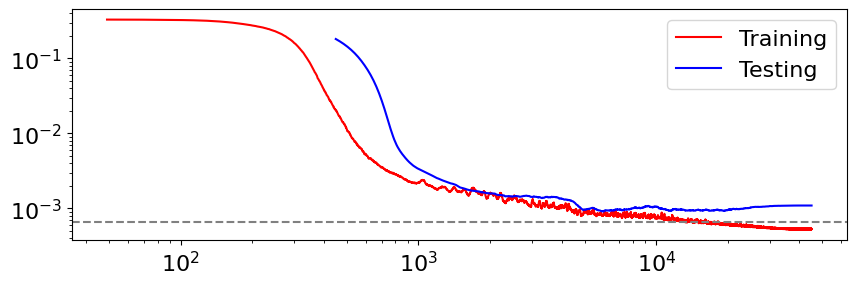

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

hist_df = pd.DataFrame(
    [
        {"step": entry.step, "loss": float(entry.loss), "loop": entry.loop}
        for entry in histories
    ]
)
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
sq.visualization.plot_loss_with_moving_average(
    x=hist_df.query("loop == 'train'")["step"].to_numpy(),
    y=hist_df.query("loop == 'train'")["loss"].to_numpy(),
    ax=ax,
    annotate_at=[],
    color="red",
    label="Training",
)

sq.visualization.plot_loss_with_moving_average(
    x=hist_df.query("loop == 'test'")["step"].to_numpy(),
    y=hist_df.query("loop == 'test'")["loss"].to_numpy(),
    ax=ax,
    annotate_at=[],
    color="blue",
    label="Testing",
)

shots = loaded_data.experiment_data.config.shots

ax.set_yscale("log")
ax.set_xscale("log")
ax.axhline(y=2/(3 * shots), linestyle='dashed', color="gray")
ax.legend()

sq.visualization.set_fontsize(ax, 16)

## Predictive model construction.

We can use the adapter function that we used to make a loss function with `partial` to create the predictive model.

In [14]:
model = sq.models.linen.WoModel(**model_state.config)
predictive_fn = sq.models.linen.make_predictive_fn(sq.model.observable_to_expvals, model, model_state.params)

Here is how can the predictive model be used to predict the expectation values given new parameters.

In [15]:
key, params_key = jax.random.split(key)
ravel_fn, _ = sq.control.ravel_unravel_fn(loaded_data.control_sequence)
sample_params = ravel_fn(loaded_data.control_sequence.sample_params(params_key))

unitary_f = loaded_data.whitebox(sample_params)[-1]
predictive_fn(sq.experimental.predefined.drag_feature_map(sample_params), unitary_f)

Array([ 0.97592831, -0.97592831,  0.21467204, -0.21467204, -0.03846735,
        0.03846735, -0.21788028,  0.21788028,  0.93792491, -0.93792491,
       -0.26986097,  0.26986097, -0.06279922,  0.06279922,  0.29283661,
       -0.29283661,  0.95409799, -0.95409799], dtype=float64)

Even more elegant, we can define a predictive model with the `whitebox` embeded as follows.

In [16]:
def embed_predictive_model(control_parameters: jnp.ndarray):
    unitary_f = loaded_data.whitebox(control_parameters)[-1]
    return predictive_fn(
        sq.experimental.predefined.drag_feature_map(control_parameters), unitary_f
    )

embed_predictive_model(sample_params)

Array([ 0.97592831, -0.97592831,  0.21467204, -0.21467204, -0.03846735,
        0.03846735, -0.21788028,  0.21788028,  0.93792491, -0.93792491,
       -0.26986097,  0.26986097, -0.06279922,  0.06279922,  0.29283661,
       -0.29283661,  0.95409799, -0.95409799], dtype=float64)

## Control Calibration

As an example, we are going to use the predictive model to calibrate for the quantum gate. Specifically, we want to find a control parameters that maximize an average gate fidelity with respected to $\sqrt{X}$ gate. First, we define a cost function that the optimizer should find the parameters that minimize its output. 

In [17]:
calculate_agf_sx = sq.physics.direct_AGF_estimation_fn(sq.constant.SX)

@jax.jit
def average_gate_infidelity(params: jnp.ndarray):
    # Predict the expectation values
    predicted_expvals = embed_predictive_model(params)
    # Calculate the average gate fidelity with respected to SX gate.
    AGF = calculate_agf_sx(predicted_expvals)
    # return average gate infidelity squared and log the results.
    return (1 - AGF) ** 2, {"AGF": AGF}

average_gate_infidelity(sample_params)

(Array(0.05932262, dtype=float64), {'AGF': Array(0.75643765, dtype=float64)})

Now, we can optimize it using `sq.optimize.minimize`.

In [18]:
init_key = jax.random.key(73)
init_params = ravel_fn(loaded_data.control_sequence.sample_params(init_key))

lower, upper = loaded_data.control_sequence.get_bounds()

steps = 400
optimized_params, aux = sq.optimize.minimize(
    init_params,
    average_gate_infidelity,
    sq.optimize.get_default_optimizer(steps),
    ravel_fn(lower),
    ravel_fn(upper),
    maxiter=steps,
)

In [19]:
optimized_params

Array([ 1.22131457, -2.00919469], dtype=float64)

In [20]:
aux[-1]

{'AGF': Array(0.97707262, dtype=float64),
 'params': Array([ 1.22131457, -2.00919469], dtype=float64)}

## Benchmark

Let's check if the model can accurately characterized the hidden device.

In [21]:
def quantum_device(params: jnp.ndarray):
    return sq.v2.models.shared.get_predict_expectation_value(
        {"X": sq.constant.X, "Y": sq.constant.Y, "Z": sq.constant.Z},
        data_model.solver(params)[-1],
        sq.constant.default_expectation_values_order,
    )

In [22]:
assert isinstance(optimized_params, jnp.ndarray)
real_expvals = quantum_device(optimized_params)

calculate_agf_sx(real_expvals)

Array(0.97586211, dtype=float64)

As a final thought:
- This is the benchmark without taking the finite-shot effect into the account.
- This is characterization without a model selection process such as hyperparameter tuning.